In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import random

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

In [3]:
# import the data
df = pd.read_csv("collected data9.6.2019/merged_data.csv", index_col=0)

In [4]:
# calculate total minutes of play time for each player by reversing formula spm * minutes = score
df['minutes'] = df['score']/df['spm']
df['kpm'] = df['kills']/df['minutes']

In [5]:
# through the previous EDA we recall that it's best to eliminate top 1% and bottom 1% of players based on spm
upper = np.percentile(df.spm, 99)
lower = np.percentile(df.spm, 1)

df = df[(df['spm'] >= lower) & (df['spm'] <= upper)]

In [6]:
# Create arrays for features and target variable
y = df['spm'].values
X = df['kpm'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1,1)
X = X.reshape(-1,1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (37081,)
Dimensions of X before reshaping: (37081,)
Dimensions of y after reshaping: (37081, 1)
Dimensions of X after reshaping: (37081, 1)


### Linear Regression - Single Independent Variable for testing

In [7]:
# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

# Fit the model to the data
reg.fit(X, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(reg.score(X, y))

0.004903279484539835


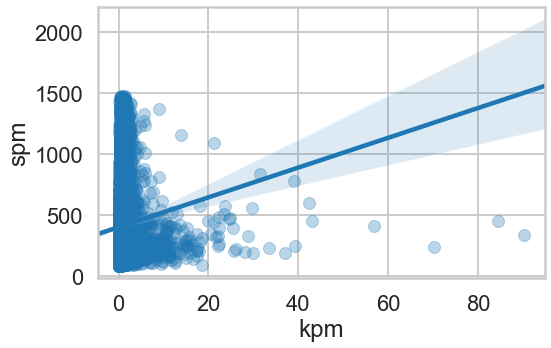

In [8]:
# Plot regression line
_ = plt.figure(figsize=(8,5))
_ = sns.regplot('kpm', 'spm', data=df, fit_reg = True, scatter_kws={'alpha':0.3})

Conclusion: The R^2 and plot could signify that there are multiple factors that contribute to a high score per minute(spm). Kills per minute alone does not explain why a player is able to obtain a high score per minute(spm).


### Feature Cleanup

In [9]:
# remove columns with duplicate values along with rankings, id, unlocks, medals
x_cols = df.drop(['player_id','time','ladder_rank','score','skill',
                  'battle_rank','scores.rankScore','extra.spm','extra.gspm',
                  'extra.medals','extra.ribbonsUnique','extra.medalsUnique',
                  'extra.ribbons','extra.ribpr','scores.unlock'],axis=1)
x_cols.shape

(37081, 247)

In [10]:
X = x_cols.drop(['spm'],axis = 1)
y = x_cols.spm

In [11]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### Cross Validation

In [12]:
# Cross Validation
from sklearn.model_selection import train_test_split
random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27810, 246)
(27810,)
(9271, 246)
(9271,)


### Random Forest

In [14]:
#Import randomforest regressor model
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

In [15]:
regr.fit(X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [16]:
# make predictions on the testing set
y_pred = np.array(regr.predict(X_test))

In [17]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

108.73854305468484


In [18]:
# calculate MAE using scikit-learn
print(metrics.mean_absolute_error(y_test, y_pred))

75.67440087275529


In [19]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.8016530021567668
0.7998827535818862


### Support Vector Machine

In [20]:
#Import support vector machine for regression model
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)

In [21]:
clf.fit(X_test, y_test)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
# make predictions on the testing set
y_pred = np.array(clf.predict(X_test))

In [23]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

222.05175816528802


In [24]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

152.48444087932725


In [25]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.17288281493860214
0.16550078731007467


### Lasso Regression

In [26]:
#Import linear model and load lasso
from sklearn import linear_model
clf = linear_model.Lasso(alpha= 4, tol = 1)

In [27]:
clf.fit(X_test, y_test)

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=1, warm_start=False)

In [28]:
# make predictions on the testing set
y_pred = np.array(clf.predict(X_test))

In [29]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

124.07923256912454


In [30]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

80.06656670494704


In [31]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.7417402006316467
0.7394352298140792


### Ridge Regression

In [32]:
#Import linear model and load ridge
from sklearn.linear_model import Ridge

In [33]:
clf = Ridge(alpha=0.5)

In [34]:
clf.fit(X_test, y_test)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [35]:
# make predictions on the testing set
y_pred = np.array(clf.predict(X_test))

In [36]:
# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

111.82514466950511


In [37]:
# calculate MAE using scikit-learn
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

72.69792575740283


In [38]:
# calculate Rsquare using scikit-learn
print(metrics.r2_score(y_test, y_pred))

# calculate adjusted Rsquare
r_squared = metrics.r2_score(y_test, y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print(adjusted_r_squared)

0.790232815419692
0.7883606415849587


### Summary Table

|          | Random Forest | Support Vector Machine | Lasso Regression | Ridge Regression |
|----------|---------------|------------------------|------------------|------------------|
| RMSE     | 108.73        | 222.05                 | 124.07           | 111.82           |
| MAE      | 75.67         | 152.48                 | 80.06            | 72.69            |
| R^2 adj. | 0.799         | 0.165                  | 0.739            | 0.788            |

### How to read feature importances?

In [39]:
# print out 20 feature importances
print(regr.feature_importances_[:20]) 

[0.00000000e+00 2.65413536e-03 0.00000000e+00 1.28233809e-04
 0.00000000e+00 0.00000000e+00 2.82739055e-04 5.87562298e-05
 4.12115521e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.17343882e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.42114774e-04 0.00000000e+00 6.93920390e-04]
